In [87]:
import pickle

import matplotlib.pyplot as plt
import pandas as pd
from yellowbrick.model_selection import LearningCurve
from sklearn.metrics import accuracy_score
import json
import matplotlib.pyplot as plt
from sklearnex import patch_sklearn
import numpy as np
patch_sklearn()
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv  # noqa
# now you can import normally from model_selection
from sklearn.model_selection import train_test_split
from drowsiness_detection.data import get_feature_data, preprocess_feature_data, session_type_mapping
from drowsiness_detection import config
from sklearn.model_selection import StratifiedKFold

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [60]:
config.set_paths(30, 60)

In [61]:
with open("../logs/4/search_result.pkl", "rb") as fp:
    search_result = pickle.load(fp)

cv_results = pd.DataFrame.from_dict(search_result.cv_results_)
cv_results.head()

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__n_estimators,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0,1,2.444833,0.147191,0.039136,0.019357,entropy,175,sqrt,1,...,0.927130,0.919220,0.924234,0.923931,0.918961,0.923758,0.914902,0.927479,0.923202,0.004112
1,0,1,2.270167,0.151969,0.034817,0.013703,entropy,72,sqrt,1,...,0.919091,0.921554,0.925142,0.926222,0.926222,0.920430,0.920650,0.928646,0.923483,0.003367
2,0,1,2.315185,0.095466,0.043309,0.020260,entropy,57,sqrt,1,...,0.915158,0.927000,0.924709,0.925833,0.919869,0.925617,0.922465,0.919440,0.921023,0.004615
3,0,1,2.246947,0.129121,0.044954,0.021623,entropy,138,sqrt,1,...,0.915590,0.925055,0.922332,0.919004,0.921511,0.921381,0.924324,0.923502,0.922264,0.002964
4,0,1,2.163229,0.179993,0.037004,0.012346,entropy,180,sqrt,1,...,0.919134,0.924580,0.929075,0.927086,0.918140,0.921252,0.925361,0.916328,0.922199,0.004498


In [62]:
best_params = search_result.best_params_
print(best_params)
best_model_results = cv_results.where((cv_results["param_classifier__criterion"] == "entropy") & (
        cv_results["param_classifier__max_depth"] == 110) & (cv_results[
                                                                 "param_classifier__max_features"] == "sqrt")).dropna()
best_model_results

{'classifier__criterion': 'entropy', 'classifier__max_depth': 110, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 16}


,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__n_estimators,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
12,0.0,1.0,2.104659,0.132530,0.037048,0.012661,entropy,110,sqrt,1,...,0.921468,0.928383,0.920214,0.927086,0.926870,0.926784,0.923762,0.922811,0.924252,0.002661
23,1.0,4.0,4.834700,0.128169,0.045796,0.017185,entropy,110,sqrt,4,...,0.980335,0.978995,0.978562,0.977957,0.978562,0.979513,0.978866,0.980033,0.979440,0.001110
25,2.0,16.0,15.397169,0.239147,0.058150,0.023178,entropy,110,sqrt,16,...,0.999741,0.999827,0.999611,0.999784,0.999741,0.999870,0.999914,0.999784,0.999801,0.000087


In [63]:
best_model_results["params"] = best_model_results["params"].apply(lambda x: json.dumps(x))
best_model_results = best_model_results.drop_duplicates(subset=("params", "iter"))

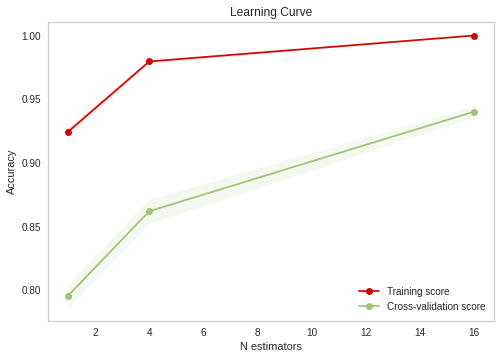

In [64]:
plt.figure()
plt.title("Learning Curve")
plt.xlabel("N estimators")
plt.ylabel("Accuracy")
train_sizes = best_model_results["param_classifier__n_estimators"].astype(int)
train_scores_mean = best_model_results["mean_train_score"]
train_scores_std = best_model_results["std_train_score"]
test_scores_mean = best_model_results["mean_test_score"]
test_scores_std = best_model_results["std_test_score"]
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

In [65]:
best_estimator = search_result.estimator.set_params(**best_params)
n_splits = 2
seed = 123
test_size = .2
num_targets = 2
exclude_by = 'a'


In [66]:
data = get_feature_data(data_path=config.PATHS.WINDOW_FEATURES)
X, y = preprocess_feature_data(feature_data=data,
                               exclude_sess_type=session_type_mapping[exclude_by],
                               num_targets=num_targets)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                    random_state=seed)

In [67]:
cv = StratifiedKFold(n_splits=n_splits, random_state=seed,
                     shuffle=True)
visualizer = LearningCurve(estimator=best_estimator, scoring="accuracy", n_jobs=-1)

KeyboardInterrupt: 

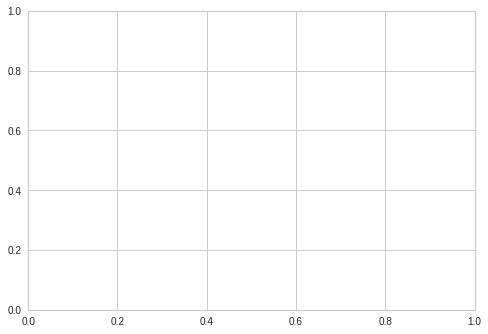

In [68]:
visualizer.fit(X_train[:100], y_train[:100])
visualizer.show()

plot accuracy while fitting more trees

In [69]:
warm_start_params = best_params.copy()
warm_start_params['classifier__n_estimators'] = 0
warm_start_params["classifier__warm_start"] = True
warm_start_params['classifier__n_jobs'] = -2

best_estimator = search_result.estimator.set_params(**warm_start_params)


In [1]:
scaler = best_estimator.named_steps['scaler']
classifier = best_estimator.named_steps['classifier']

NameError: name 'best_estimator' is not defined

In [ ]:
test_errors = []
train_errors = []

X_train_scaled = scaler.fit_transform(X_train, y_train)
X_test_scaled = scaler.transform(X_test)

n_estimator_options = np.logspace(2, 11, num=20, base=2)
print(n_estimator_options)
for added_estimators in n_estimator_options:
    classifier.n_estimators += added_estimators
    classifier.n_estimators = int(classifier.n_estimators)

    classifier.fit(X_train_scaled, y_train)
    y_hat_train = classifier.predict(X_train_scaled)
    y_hat_test = classifier.predict(X_test_scaled)

    train_errors.append(accuracy_score(y_train, y_hat_train))
    test_errors.append(accuracy_score(y_test, y_hat_test))


[   4.            5.55460457    7.71340798   10.71123281   14.87416568
   20.65502717   28.68262708   39.83016286   55.31020117   76.80657405
  106.65753682  148.11011037  205.673274    285.60842695  396.61046842
  550.75358014  764.80458837 1062.04676551 1474.81245444 2048.        ]


In [ ]:
_ = plt.plot(n_estimator_options, train_errors, '-r')

In [ ]:
_ = plt.plot(n_estimator_options, test_errors, '-r')
